### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit classic models: ols as a baseline, then xgb.
6. Fir DL.


Notes:
ideally, I want to use time-based cross-validation.
since I have panel data, it is not a trivial task.
need to find some solution online.
e.g., https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8.


In [25]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, time, math, re, warnings, random, gc, dill, optuna
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [26]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [27]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [29]:
# 1. Import data #

time0 = time.time()
df = pd.read_csv('../input/cpcrsp-46/IMLEAP_v4.csv')
df.dropna(axis=0, subset=['bm', 'lbm', 'llme', 'lop', 'op', 'linv', 'mom122', 'beta_bw', 'ind'], inplace=True)
df.reset_index(inplace=True, drop=True)
df = df.sample(500000)
display(df.shape, df.head(), df.count())

(500000, 46)

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m
124460,14533,124,9.013889,37.639513,1968,1.2710,2.0,-0.703278,0.166651,0.651314,0.278148,-1.059700,12.982248,2.027949,0.765013,0.647098,0.730934,1.406600,0.992017,1.706765,1.602684,NaN,6.334559,-0.821521,0.182498,0.704945,0.052272,6.208594,2.079856,2.9249,NaN,2.159957,5.7613,NaN,2.123702,2.8391,NaN,2.454088,2.9249,NaN,18.081899,1.169551,1.074638,0.852332,1.238122,1.653640
418314,36142,186,-28.658006,170.270066,1973,-21.1628,23.0,-0.826631,0.032258,0.142237,0.333585,26.592465,-61.937195,6.998093,7.874195,6.946893,1.293825,21.135115,8.239788,6.641868,5.501024,NaN,1.007867,-1.467710,-0.164025,0.025660,-0.012422,1.581038,6.890220,11.5979,NaN,6.383651,11.5145,NaN,5.528735,6.2290,NaN,6.850087,11.5979,NaN,105.899232,2.205730,1.611875,2.063918,3.732448,5.808877
153420,16791,334,NaN,39.703780,1986,13.1605,43.0,-0.103521,0.221755,0.875338,0.483727,19.440000,105.899232,4.969996,2.031718,1.626541,0.218155,4.520500,2.070030,3.045736,4.132032,NaN,3.507942,-1.471208,0.109675,0.746991,0.051571,1.712558,5.115119,3.9164,NaN,5.777382,13.1795,NaN,5.821803,4.9103,NaN,NaN,3.9164,NaN,-61.937195,2.157976,2.034485,0.410679,2.559675,2.604044
782809,62376,649,-36.477058,51.465238,2012,-10.5996,41.0,0.859468,0.054783,0.107195,0.173348,15.032400,3.430639,1.770258,3.177744,2.664914,1.520047,7.265700,4.104987,3.758698,3.960404,0.07946,5.804482,0.736873,0.055082,0.113484,0.036444,5.630611,1.710462,8.5492,0.567491,1.675587,4.6699,0.309358,1.582174,19.4215,1.290323,1.450566,8.5492,0.333969,6.280244,1.401304,1.226691,1.524502,2.640329,3.148657
832286,66747,369,-73.852485,-45.648759,1989,-12.3147,44.0,0.767562,0.032514,0.146985,-0.190260,-0.630000,-10.817906,6.682770,5.305862,4.908116,0.891857,7.112900,5.340215,5.048165,5.362990,NaN,2.147538,0.609390,0.038800,0.282895,-0.079604,2.204697,6.682653,15.3576,NaN,6.799326,7.6633,NaN,6.234400,6.6447,NaN,6.024024,15.3576,NaN,-60.856614,7.874195,6.946893,1.180779,7.983689,6.639848


PERMNO          500000
prd             500000
mom482          425883
mom242          490590
year            500000
RET             500000
ind             500000
bm              500000
op              500000
gp              500000
inv             499556
mom11           500000
mom122          500000
amhd            411493
ivol_capm       499975
ivol_ff5        499975
beta_bw         500000
MAX             500000
vol1m           499927
vol6m           499547
vol12m          498829
BAspr           290729
size            500000
lbm             500000
lop             500000
lgp             500000
linv            500000
llme            500000
l1amhd          411210
l1MAX           499983
l1BAspr         290012
l3amhd          410769
l3MAX           499884
l3BAspr         288453
l6amhd          409847
l6MAX           499779
l6BAspr         285965
l12amhd         407596
l12MAX          499983
l12BAspr        281156
l12mom122       496519
l12ivol_capm    499482
l12ivol_ff5     499482
l12beta_bw 

<AxesSubplot:>

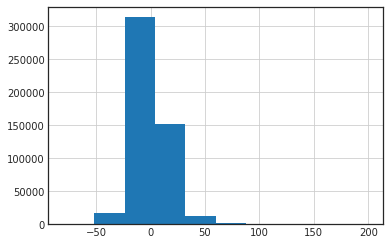

In [30]:
# 2. pEDA #

df.RET.hist()

In [31]:
# explore feature distibution, adjust if seems unreasonable

In [32]:
# add dummies for some missing features

features_miss_dummies = ['amhd', 'BAspr']

for col in features_miss_dummies:
    df[col+'_miss'] = df[col].isnull().astype(int)

df.head()

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
124460,14533,124,9.013889,37.639513,1968,1.2710,2.0,-0.703278,0.166651,0.651314,0.278148,-1.059700,12.982248,2.027949,0.765013,0.647098,0.730934,1.406600,0.992017,1.706765,1.602684,NaN,6.334559,-0.821521,0.182498,0.704945,0.052272,6.208594,2.079856,2.9249,NaN,2.159957,5.7613,NaN,2.123702,2.8391,NaN,2.454088,2.9249,NaN,18.081899,1.169551,1.074638,0.852332,1.238122,1.653640,0,1
418314,36142,186,-28.658006,170.270066,1973,-21.1628,23.0,-0.826631,0.032258,0.142237,0.333585,26.592465,-61.937195,6.998093,7.874195,6.946893,1.293825,21.135115,8.239788,6.641868,5.501024,NaN,1.007867,-1.467710,-0.164025,0.025660,-0.012422,1.581038,6.890220,11.5979,NaN,6.383651,11.5145,NaN,5.528735,6.2290,NaN,6.850087,11.5979,NaN,105.899232,2.205730,1.611875,2.063918,3.732448,5.808877,0,1
153420,16791,334,NaN,39.703780,1986,13.1605,43.0,-0.103521,0.221755,0.875338,0.483727,19.440000,105.899232,4.969996,2.031718,1.626541,0.218155,4.520500,2.070030,3.045736,4.132032,NaN,3.507942,-1.471208,0.109675,0.746991,0.051571,1.712558,5.115119,3.9164,NaN,5.777382,13.1795,NaN,5.821803,4.9103,NaN,NaN,3.9164,NaN,-61.937195,2.157976,2.034485,0.410679,2.559675,2.604044,0,1
782809,62376,649,-36.477058,51.465238,2012,-10.5996,41.0,0.859468,0.054783,0.107195,0.173348,15.032400,3.430639,1.770258,3.177744,2.664914,1.520047,7.265700,4.104987,3.758698,3.960404,0.07946,5.804482,0.736873,0.055082,0.113484,0.036444,5.630611,1.710462,8.5492,0.567491,1.675587,4.6699,0.309358,1.582174,19.4215,1.290323,1.450566,8.5492,0.333969,6.280244,1.401304,1.226691,1.524502,2.640329,3.148657,0,0
832286,66747,369,-73.852485,-45.648759,1989,-12.3147,44.0,0.767562,0.032514,0.146985,-0.190260,-0.630000,-10.817906,6.682770,5.305862,4.908116,0.891857,7.112900,5.340215,5.048165,5.362990,NaN,2.147538,0.609390,0.038800,0.282895,-0.079604,2.204697,6.682653,15.3576,NaN,6.799326,7.6633,NaN,6.234400,6.6447,NaN,6.024024,15.3576,NaN,-60.856614,7.874195,6.946893,1.180779,7.983689,6.639848,0,1


In [33]:
# 3. Train-test split #

temp_cols = ['PERMNO', 'prd', 'year']

train = df[df.year<2016]
test = df[df.year>=2016]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train.drop(columns=temp_cols, inplace=True)
test.drop(columns=temp_cols, inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

(478954, 45)

(21046, 45)

,mom482,mom242,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
0,9.013889,37.639513,1.2710,2.0,-0.703278,0.166651,0.651314,0.278148,-1.059700,12.982248,2.027949,0.765013,0.647098,0.730934,1.406600,0.992017,1.706765,1.602684,NaN,6.334559,-0.821521,0.182498,0.704945,0.052272,6.208594,2.079856,2.9249,NaN,2.159957,5.7613,NaN,2.123702,2.8391,NaN,2.454088,2.9249,NaN,18.081899,1.169551,1.074638,0.852332,1.238122,1.653640,0,1
1,-28.658006,170.270066,-21.1628,23.0,-0.826631,0.032258,0.142237,0.333585,26.592465,-61.937195,6.998093,7.874195,6.946893,1.293825,21.135115,8.239788,6.641868,5.501024,NaN,1.007867,-1.467710,-0.164025,0.025660,-0.012422,1.581038,6.890220,11.5979,NaN,6.383651,11.5145,NaN,5.528735,6.2290,NaN,6.850087,11.5979,NaN,105.899232,2.205730,1.611875,2.063918,3.732448,5.808877,0,1
2,NaN,39.703780,13.1605,43.0,-0.103521,0.221755,0.875338,0.483727,19.440000,105.899232,4.969996,2.031718,1.626541,0.218155,4.520500,2.070030,3.045736,4.132032,NaN,3.507942,-1.471208,0.109675,0.746991,0.051571,1.712558,5.115119,3.9164,NaN,5.777382,13.1795,NaN,5.821803,4.9103,NaN,NaN,3.9164,NaN,-61.937195,2.157976,2.034485,0.410679,2.559675,2.604044,0,1


,mom482,mom242,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
0,145.738128,131.036151,28.3950,7.0,-2.233461,0.091727,0.370789,-0.048301,-7.3879,1.342561,-0.863785,1.039271,0.856870,1.276048,2.0626,1.265321,1.823538,2.718985,0.057937,6.574528,-1.802292,0.058850,0.335743,-0.169622,6.621589,-0.832456,3.7409,0.053505,-0.817994,5.693900,0.062305,-0.806025,7.0269,0.165563,-0.144257,3.7409,0.169587,105.899232,2.836631,2.347055,1.042882,3.019141,2.934520,0,0
1,150.895366,8.365179,-5.5332,43.0,-1.507180,0.094363,0.741223,0.178561,16.8509,-32.592943,0.187449,2.329873,2.120293,1.112940,5.4510,2.597804,3.556306,3.063814,0.116959,6.068495,-1.784947,0.095391,0.775690,0.757106,6.263569,0.125900,3.9757,0.196464,-0.113624,21.135115,0.131148,-0.542371,3.6398,0.076394,-0.646052,3.9757,0.138825,40.694634,1.725765,1.159777,0.997316,2.411401,2.661536,0,0
2,-13.384455,-5.724801,9.7200,33.0,-0.892905,0.082544,0.315136,0.475418,-8.6550,-5.580777,-0.284740,1.638956,1.352308,1.112851,4.3058,1.939359,2.421194,2.376146,0.080354,6.645138,-1.547001,0.090118,0.358055,0.210109,6.788767,-0.302613,5.3228,0.037764,-0.423059,4.127400,0.044228,-0.636321,6.0989,0.046275,-0.848080,5.3228,0.107028,21.874954,1.459692,1.201918,1.163704,2.068168,2.438478,0,0


In [34]:
# 4. Missing values #

col_ignore = ['RET']
col_cat = ['ind']
col_num = [x for x in train.columns if x not in col_ignore+col_cat]

for col in col_num:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

for col in col_cat:
    train[col] = train[col].fillna(value=-1000)
    test[col] = test[col].fillna(value=-1000)
    
display(train.count())

mom482          478954
mom242          478954
RET             478954
ind             478954
bm              478954
op              478954
gp              478954
inv             478954
mom11           478954
mom122          478954
amhd            478954
ivol_capm       478954
ivol_ff5        478954
beta_bw         478954
MAX             478954
vol1m           478954
vol6m           478954
vol12m          478954
BAspr           478954
size            478954
lbm             478954
lop             478954
lgp             478954
linv            478954
llme            478954
l1amhd          478954
l1MAX           478954
l1BAspr         478954
l3amhd          478954
l3MAX           478954
l3BAspr         478954
l6amhd          478954
l6MAX           478954
l6BAspr         478954
l12amhd         478954
l12MAX          478954
l12BAspr        478954
l12mom122       478954
l12ivol_capm    478954
l12ivol_ff5     478954
l12beta_bw      478954
l12vol6m        478954
l12vol12m       478954
amhd_miss  

In [49]:
# [optional] Target Encoding


In [36]:
X_train = train.copy()
y_train = X_train.pop('RET')

X_test = test.copy()
y_test = X_test.pop('RET')

In [37]:
# 5. Feature engineering #

time1 = time.time()

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat),
    ('num', StandardScaler(), col_num)])

print('Number of features before transformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transformation: ', X_train.shape)



Number of features before transformation:  (478954, 44)
time to do feature proprocessing:  1.0431735515594482
Number of features after transformation:  (478954, 92)


In [38]:
X_train

,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_46.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__BAspr,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l1BAspr,num__l3amhd,num__l3MAX,num__l3BAspr,num__l6amhd,num__l6MAX,num__l6BAspr,num__l12amhd,num__l12MAX,num__l12BAspr,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,num__BAspr_miss
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.218906,0.370929,-0.308925,0.645274,1.091918,0.708540,-0.124805,0.161673,0.013353,-1.118101,-1.108794,-0.429794,-1.078262,-1.083012,-0.866507,-0.978219,-0.296025,0.708292,-0.418304,0.765620,1.329396,-0.336146,0.686098,0.029816,-0.779859,-0.294892,0.053703,-0.217746,-0.293140,0.032613,-0.801377,-0.289551,0.138379,-0.779859,-0.283089,0.273169,-0.915345,-0.862900,-0.107744,-1.144295,-0.959666,-0.474919,1.135272
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.638466,2.487226,-0.442645,-0.582898,-1.217755,0.953810,2.210518,-1.619593,1.811069,2.715115,2.719963,1.124240,2.805525,2.696477,1.900586,1.285004,-0.296025,-1.662158,-1.115891,-2.394791,-1.748651,-0.611271,-1.410105,1.773927,0.932819,-0.294892,1.591001,0.927637,-0.293140,1.279635,-0.123002,-0.289551,1.768137,0.932819,-0.283089,2.361459,-0.340340,-0.526806,3.214306,0.290409,1.521756,-0.474919,1.135272
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.245483,0.403867,0.341242,1.148853,2.108310,1.618092,1.606467,2.370843,1.077500,-0.435104,-0.513529,-1.845479,-0.465255,-0.520862,-0.115751,0.490221,-0.296025,-0.549590,-1.119668,0.101445,1.519917,-0.339130,-1.350529,1.130323,-0.584065,-0.294892,1.370337,1.259116,-0.293140,1.386965,-0.386896,-0.289551,0.099000,-0.584065,-0.283089,-1.629679,-0.366840,-0.262422,-1.318711,-0.384155,-0.392105,-0.474919,1.135272
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.725549,0.591537,1.385169,-0.377046,-1.376742,0.244867,1.234230,-0.065424,-0.079854,0.182824,0.117552,1.748795,0.075170,0.540306,0.284004,0.390581,-0.777461,0.472401,1.264047,-0.396457,-1.350695,-0.403456,0.424282,-0.104116,0.330785,-0.600390,-0.122593,-0.435029,-0.701087,-0.165710,2.517035,-0.341364,-0.233663,0.330785,-0.715054,-0.007473,-0.786739,-0.767776,1.735282,-0.337764,-0.066873,-0.474919,-0.880846
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.141807,-0.958046,1.285539,-0.580562,-1.196217,-1.363862,-0.088515,-0.404194,1.697016,1.330290,1.480878,0.014483,0.045089,1.184439,1.007003,1.204867,-0.296025,-1.154988

In [50]:
# 6. Model fitting #

# first, some trivial baselines:
print('mse of a constant model', mean_squared_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

time1 = time.time()
xgb = XGBRegressor(tree_method = 'gpu_hist', n_estimators=300, max_depth=6, eta=0.05, colsample_bytree=0.6)
xgb.fit(X_train, y_train)
print('XGB train:', mean_squared_error(y_train, xgb.predict(X_train)), r2_score(y_train, xgb.predict(X_train)), time.time()-time1)

mse of a constant model 246.36492244330125
R2 of a constant model 0.0
XGB train: 229.0785362046512 0.0806672292894085 9.895293235778809


In [52]:
time1 = time.time()
xgb = XGBRegressor(tree_method = 'gpu_hist')
param_grid = {'n_estimators':[300, 500], 'max_depth':[2,4,6], 'eta':[0.02, 0.04, 0.06],
             'subsample':[0.6], 'colsample_bytree':[0.6]}
xgbm = GridSearchCV(xgb, param_grid, cv=2, verbose=2)
xgbm.fit(X_train, y_train)
print('XGB', xgbm.best_params_, xgbm.best_score_, time.time()-time1)
# this runs for 40 min and finds 
# 'eta': 0.02, 'max_depth': 6, 'n_estimators': 500, 0.01095415380877135
print('XGB train:', mean_squared_error(y_train, xgbm.predict(X_train)), r2_score(y_train, xgbm.predict(X_train)), time.time()-time1)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=2, n_estimators=300, subsample=0.6; total time=   1.9s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=2, n_estimators=300, subsample=0.6; total time=   2.0s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=2, n_estimators=500, subsample=0.6; total time=   2.6s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=2, n_estimators=500, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=4, n_estimators=300, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=4, n_estimators=300, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=4, n_estimators=500, subsample=0.6; total time=   3.8s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=4, n_estimators=500, subsample=0.6; total time=   3.9s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=6, n_estimators=300, subsample=0.6; tota

In [ ]:
time1 = time.time()

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

    cv_regularizer=0.01
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.005, 0.2),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10)    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBRegressor(**params, njobs=-1)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict(X_B)
                      
            
        #score_train = roc_auc_score(y_train, y_pred_train)
        score_test = mean_squared_error(y_train, y_pred) 
        #overfit = score_train-score_test
        #temp_out.append(score_test-cv_regularizer*overfit)
        temp_out.append(score_test)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars = starting_hyperparameters

optuna_xgb = XGBClassifier(**optuna_hyperpars, seed=8)
optuna_xgb.fit(X_train, y_train)
print('Optuna XGB train:', 
      mean_squared_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), time.time()-time1)

[I 2022-08-24 22:28:56,748] A new study created in memory with name: no-name-285cbf6d-0f8d-4eea-8d10-5f722559fd9c
[I 2022-08-24 22:29:04,121] Trial 0 finished with value: 247.11419125260838 and parameters: {'n_estimators': 376, 'max_depth': 3, 'learning_rate': 0.05467772377871922, 'colsample_bytree': 0.1254964116210025, 'subsample': 0.7940295304746346, 'alpha': 4.3493039375588145, 'lambda': 104.21758728378975, 'gamma': 2.772044762209101e-10, 'min_child_weight': 1.541228073605977}. Best is trial 0 with value: 247.11419125260838.
[I 2022-08-24 22:29:12,127] Trial 1 finished with value: 249.9759969349031 and parameters: {'n_estimators': 205, 'max_depth': 6, 'learning_rate': 0.145078487872431, 'colsample_bytree': 0.1627912461620199, 'subsample': 0.9235419407693417, 'alpha': 1.882724582431167, 'lambda': 0.13531543105955623, 'gamma': 2.5421644364130322e-08, 'min_child_weight': 0.13120192584847673}. Best is trial 1 with value: 249.9759969349031.
[I 2022-08-24 22:29:20,178] Trial 2 finished wi

In [ ]:
# Evaluate performance of XGB models:

print('XGB test:', mean_squared_error(y_test, xgb.predict(X_test)), r2_score(y_test, xgb.predict(X_test)))
print('XGB GS test:', mean_squared_error(y_test, xgbm.predict(X_test)), r2_score(y_test, xgbm.predict(X_test)))
print('Optuna XGB test:', mean_squared_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

In [ ]:
# test_size = 0.1
# df.reset_index(inplace=True, drop=True)
# #random.seed(2)
# test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
# train = df.iloc[list(set(df.index)-set(test_index))]
# test = df.iloc[test_index]
# train.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)
# display(train.shape, test.shape, train.head(3), test.head(3))